# Confidence model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

# Sci-kit learn
from mol2ccs.confidence_model import RFStructureConfidenceModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

from utils import SeabornFig2Grid
import matplotlib.gridspec as gridspec

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Get data

In [4]:
ccsbase_full = pd.read_parquet(
    "ccs-prediction/ccsbase_3d.parquet",
)


metlin_full = pd.read_parquet(
    "ccs-prediction/metlin_3d.parquet",
)

In [5]:
relevant_cols = [
    "dimer",
    "source",
    "mol_type",
    "ccs_type",
    "drugtax",
    "type_dimer",
    "smiles_adduct",
]

metlin_full = metlin_full[relevant_cols]
ccsbase_full = ccsbase_full[relevant_cols]

In [6]:
predictions = {}

for name, path in zip(
    [
        "ccsbase predictions from metlin",
        "ccsbase test",
        "metlin predictions from ccsbase",
        "metlin test",
    ],
    [
        "ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_3d_pred.parquet",  # 5% error -> good
        "ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_test_3d_pred.parquet",  # 0.05% error is necessary because the model is pretty good
        "ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_3d_pred.parquet",  # 5% error -> good
        "ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_test_3d_pred.parquet",
    ],
):
    preds = pd.read_parquet(path)

    preds["smiles_adduct"] = preds["smiles"] + "_" + preds["adduct"]

    if "ccsbase" in path:
        preds = preds.merge(ccsbase_full, on="smiles_adduct", how="left")
    else:
        preds = preds.merge(metlin_full, on="smiles_adduct", how="left")

    train, test = train_test_split(preds, test_size=0.2, random_state=42)

    predictions[name] = {
        "train": train,
        "test": test,
    }

# Get model

In [7]:
confidence_preds = {}
models_dict = {}

for prediction_file in tqdm(predictions):
    # Skip test files since their performance is already pretty good
    if "test" in prediction_file:
        continue

    print(f"Training model for {prediction_file}")

    train, test = (
        predictions[prediction_file]["train"],
        predictions[prediction_file]["test"],
    )

    error_threshold = 0.05  # 5% error

    model = RFStructureConfidenceModel(
        # estimator_type="regressor",
        # target_type="error",
        # Alternative:
        estimator_type="classifier",
        target_type="binary_error",
    )

    model.fit(
        train,
        hpo_params={
            "n_estimators": [50, 100, 200, 400],
            "max_depth": [None, 10, 20, 50],
            "min_samples_split": [2, 5, 20],
        },
        error_threshold=error_threshold,
    )

    test["confs"] = model.predict_confidence(test)

    test["errors"] = abs(test["ccs"] - test["pred_ccs"])

    confidence_preds[prediction_file] = test
    models_dict[prediction_file] = model

  0%|          | 0/4 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: False    4770
True     3846
Name: count, dtype: int64
            % of True labels: 44.64%
            % of False labels: 55.36%
            


/Users/danieldomingo/repos/sigmaccs-enveda/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 25%|██▌       | 1/4 [00:24<01:13, 24.34s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     37143
False    12341
Name: count, dtype: int64
            % of True labels: 75.06%
            % of False labels: 24.94%
            


/Users/danieldomingo/repos/sigmaccs-enveda/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 4/4 [02:49<00:00, 42.25s/it]


In [8]:
name_style = {
    "ccsbase predictions from metlin": "METLIN-CCS (train) CCSBase (test)",
    "metlin predictions from ccsbase": "CCSBase (train) METLIN-CCS (test)",
}

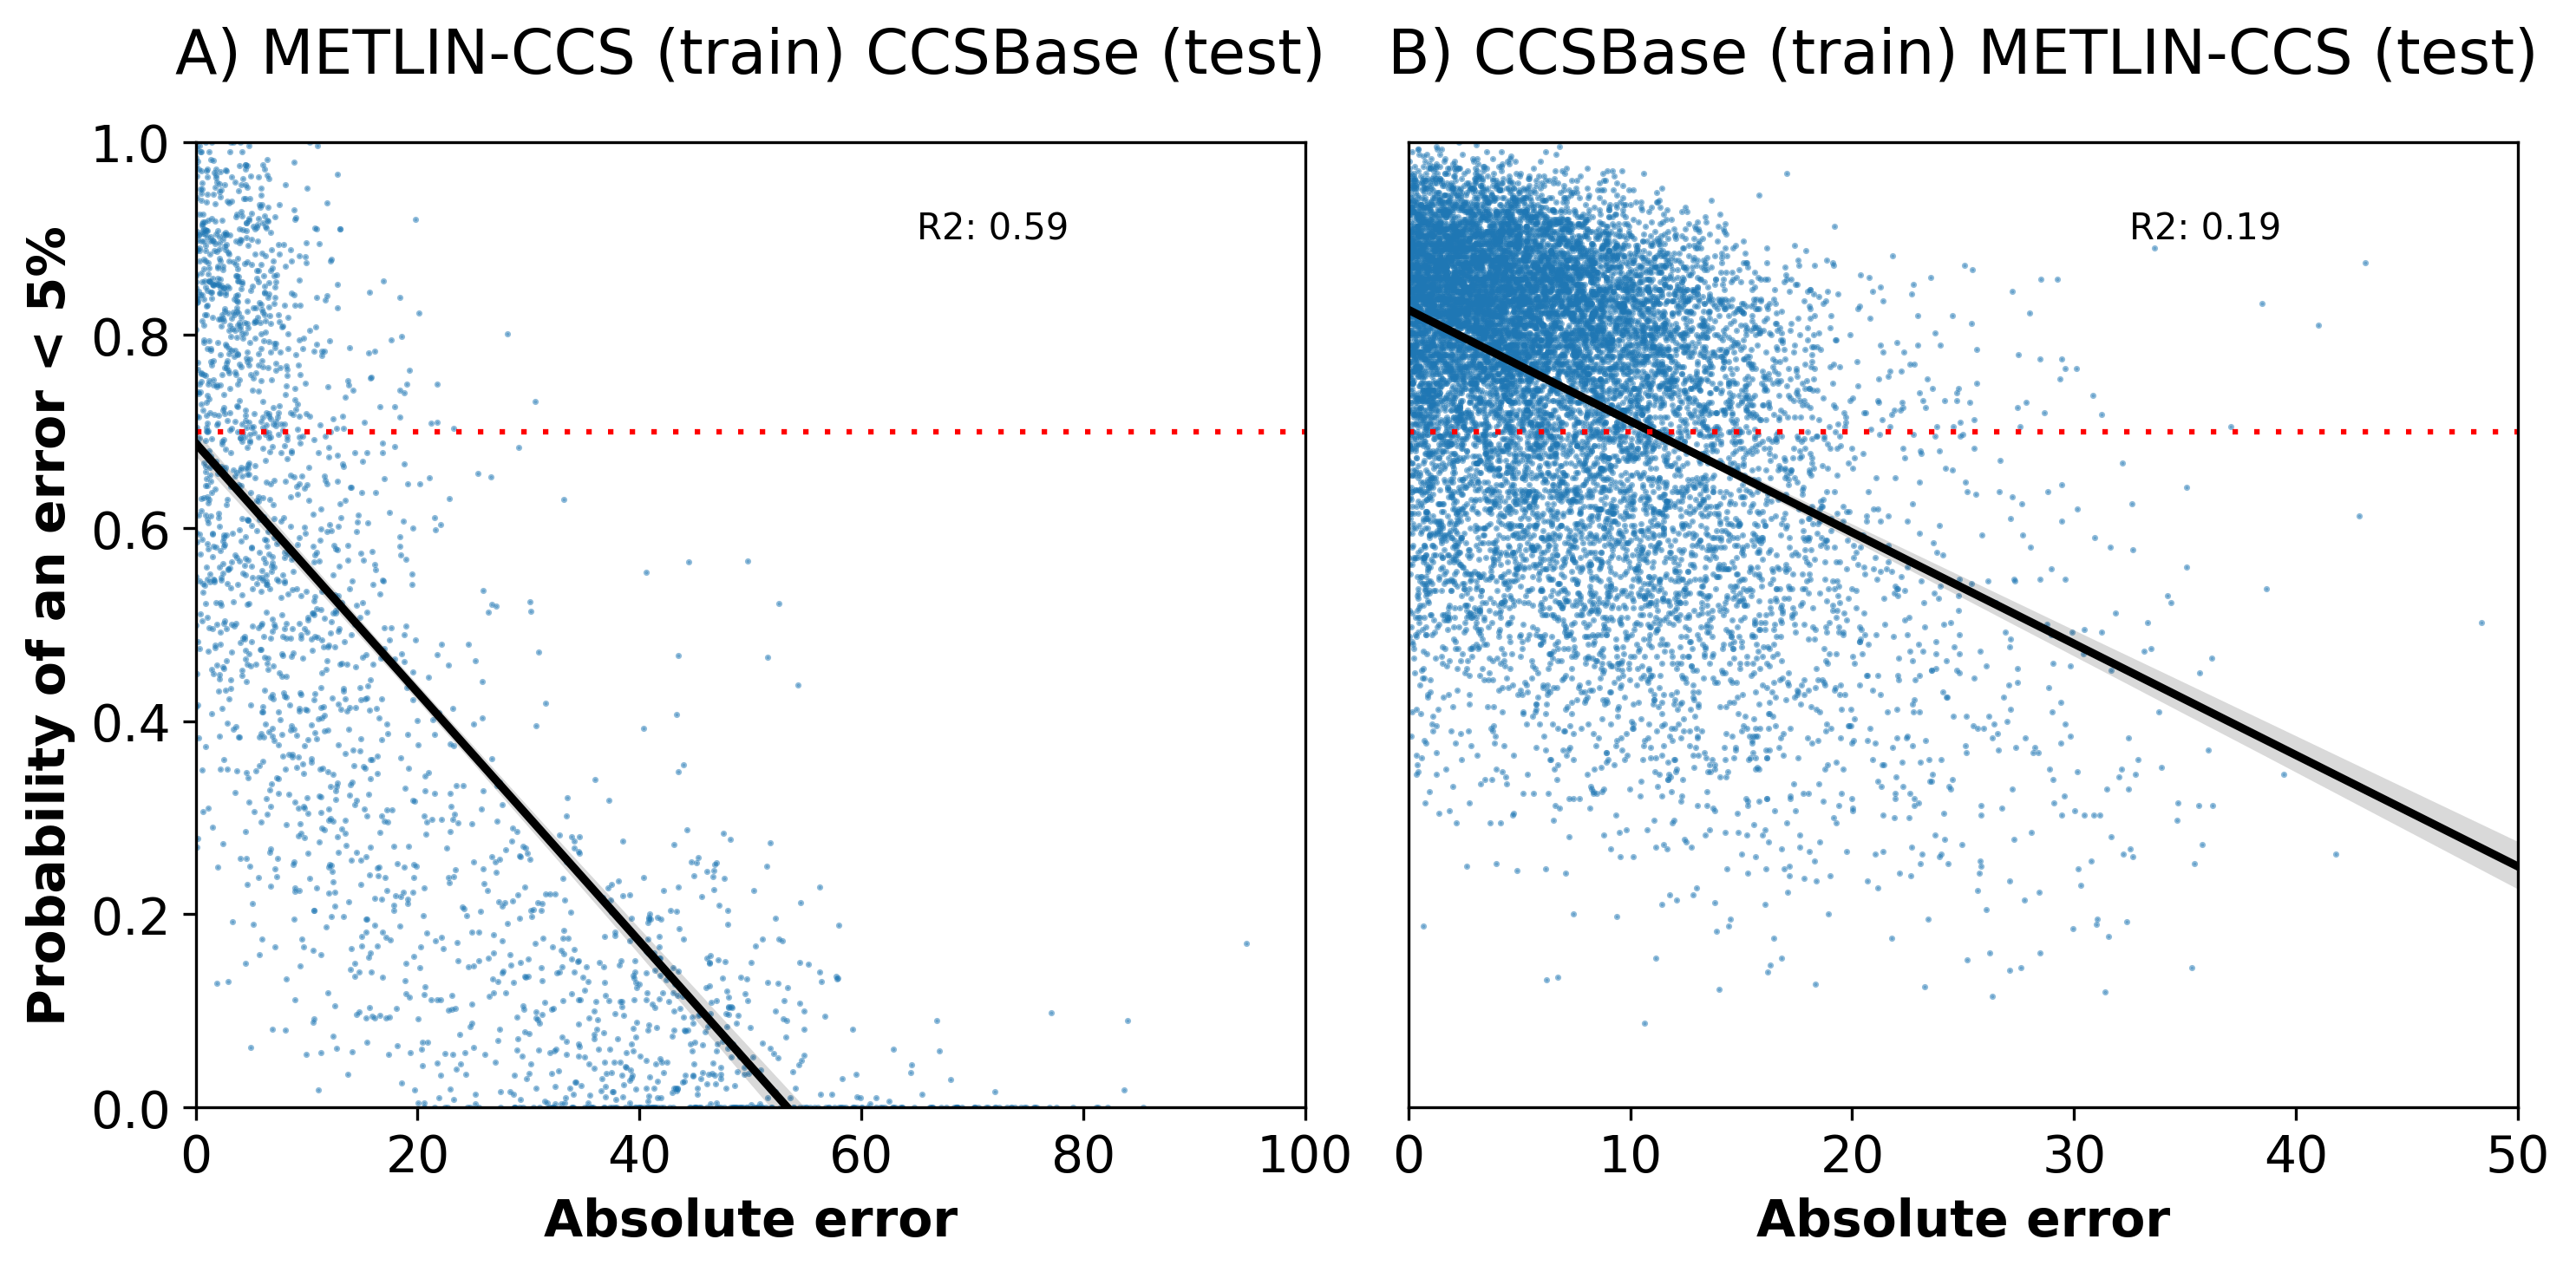

In [18]:
# Make a 2x2 plot of the results with a regression line

fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

for i, prediction_file in enumerate(confidence_preds):
    prediction_df = confidence_preds[prediction_file]

    # Axes limits
    if "test" in prediction_file:
        continue

    elif "ccsbase predictions from metlin" in prediction_file:
        size_factor = 0.5
    else:
        size_factor = 0.5

    # regression plot
    sns.regplot(
        x="errors",
        y="confs",
        data=prediction_df,
        scatter_kws={"s": size_factor, "alpha": 0.5},
        line_kws={"color": "black"},
        ax=axs[i],
    )

    if i == 0:
        title = f"A) {name_style[prediction_file]}"
    else:
        title = f"B) {name_style[prediction_file]}"

    axs[i].set_title(title, fontsize=17, y=1.05)
    axs[i].set_xlabel("Absolute error", fontsize=14, fontweight="bold")

    # show only if it's the first column
    if i % 2 == 0:
        axs[i].set_ylabel(
            "Probability of an error < 5%", fontweight="bold", fontsize=14
        )
    else:
        axs[i].set_ylabel("")
        axs[i].set_yticks([])

    # Axes limits
    if "test" in prediction_file:
        axs[i].set_xlim(0, 40)

    elif "ccsbase predictions from metlin" in prediction_file:
        axs[i].set_xlim(0, 100)
    else:
        axs[i].set_xlim(0, 50)

    # larger ticks x and y
    axs[i].tick_params(axis="both", which="major", labelsize=14)

    # calculate r2 and plot it
    r2 = prediction_df["confs"].corr(prediction_df["errors"]) ** 2
    axs[i].text(
        0.65,
        0.90,
        f"R2: {r2:.2f}",
        fontsize=10,
        transform=axs[i].transAxes,
        color="black",
    )

    # add a horizonal line on 0.7
    axs[i].axhline(y=0.7, color="r", linestyle=(0, (1, 3)))

    axs[i].set_ylim(0, 1)

plt.tight_layout()

# save
plt.savefig("confidence_model.png", dpi=600)

plt.show()

What you see is that the first column (when we trained on one database, and predict on the other) looks correlated. This is not surprising because those are the models that show a worse prediction (R2=0.9), so the confidence model seems to be able to pick up why some predictions are a bit more off than others based on the fingerprints + adduct.

To make the binary classifier, in the first column, we are using 5% as a cutoff. However, for the second column (test sets of the same database), the model already knows the chemical space since it has been trained on the same database, and it's already accurate (R2=0.98), so the model cannot pick up differences between the predictions and hence, there is no correlation.
To make the binary classifier, in the second column, we are using 2% as a cutoff, because the error is much lower here, so a 5% cutoff almost doesnt have any "off" examples.

In [10]:
#  Iterate through the predictions again and calculate precision and recall for the different thresholds

cutoffs = defaultdict(dict)

for prediction_file in confidence_preds:
    if "from" not in prediction_file:
        print(f"Skipping {prediction_file} because preds are not good")
        continue

    prediction_df = confidence_preds[prediction_file]
    model = models_dict[prediction_file]

    for threshold in range(1, 10, 1):
        threshold /= 10

        # get the predictions that pass the confidence threshold
        # preds_after_cutoff = prediction_df[prediction_df["confs"] >= threshold]

        # if y is less than 5% of the true CCS, set to True, else False
        y = prediction_df["ccs"] - prediction_df["pred_ccs"]
        y = y.abs()
        labels = y < (error_threshold * prediction_df["ccs"])

        # calculate labels based on whether the error is larger than 0.05

        # Make the model predict
        # pred_labels = model.predict_label(
        #     preds_after_cutoff,
        # )
        pred_labels = prediction_df["confs"] >= threshold

        # change labels and pred_labels to 0 and 1 from True and False
        labels = labels.astype(int)
        pred_labels = pred_labels.astype(int)

        # print(
        #     f"""
        #       Threshold {threshold}
        #       # of predictions: {preds_after_cutoff.shape[0]}
        #       % of True / False predictions: {preds_after_cutoff['labels'].value_counts(normalize=True)}

        #       """
        # )

        precision = precision_score(labels, pred_labels)
        recall = recall_score(labels, pred_labels)
        f1 = f1_score(labels, pred_labels)
        accuracy = accuracy_score(labels, pred_labels)
        auc_roc = roc_auc_score(labels, pred_labels)

        cutoffs[prediction_file][threshold] = {
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "accuracy": accuracy,
            "auc_roc": auc_roc,
            "labels": labels,
            "pred_labels": pred_labels,
        }

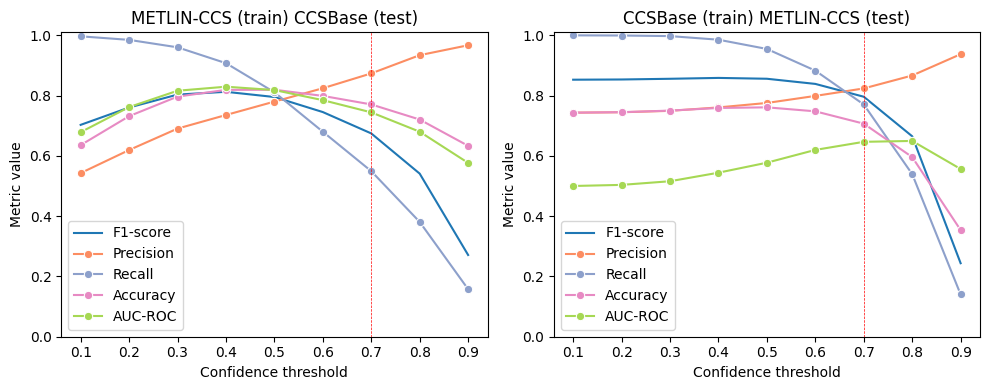

In [11]:
# Plot the metrics for the different thresholds for both datasets

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

metric_palette = sns.color_palette("Set2")

for i, prediction_file in enumerate(cutoffs):
    if "from" not in prediction_file:
        continue

    cutoffs_df = pd.DataFrame(cutoffs[prediction_file]).T

    sns.lineplot(
        x=cutoffs_df.index,
        y=cutoffs_df["f1"],
        ax=axs[i],
        label="F1-score",
        # # Add points
        # marker="o",
        # color=metric_palette[0],
    )

    sns.lineplot(
        x=cutoffs_df.index,
        y=cutoffs_df["precision"],
        ax=axs[i],
        label="Precision",
        # Add points
        marker="o",
        color=metric_palette[1],
    )

    sns.lineplot(
        x=cutoffs_df.index,
        y=cutoffs_df["recall"],
        ax=axs[i],
        label="Recall",
        # Add points
        marker="o",
        color=metric_palette[2],
    )

    sns.lineplot(
        x=cutoffs_df.index,
        y=cutoffs_df["accuracy"],
        ax=axs[i],
        label="Accuracy",
        # Add points
        marker="o",
        color=metric_palette[3],
    )

    sns.lineplot(
        x=cutoffs_df.index,
        y=cutoffs_df["auc_roc"],
        ax=axs[i],
        label="AUC-ROC",
        # Add points
        marker="o",
        color=metric_palette[4],
    )

    # title
    axs[i].set_title(name_style[prediction_file])
    axs[i].set_xlabel("Confidence threshold")
    axs[i].set_ylabel("Metric value")
    axs[i].set_ylim(0, 1.01)

    # legend
    axs[i].legend()

    # vertical line 0.7
    axs[i].axvline(
        0.7,
        color="red",
        linestyle="--",
        # tickness
        lw=0.5,
    )

plt.tight_layout()

# Save with dpi 400
plt.savefig("threshold_metrics.png", dpi=400)

plt.show()

In [12]:
threshold = 0.7

for prediction_file in cutoffs:
    if "from" not in prediction_file:
        continue

    labels = cutoffs[prediction_file][threshold]["labels"]
    pred_labels = cutoffs[prediction_file][threshold]["pred_labels"]

    cm = confusion_matrix(labels, pred_labels)

    print(f"Confusion matrix for {prediction_file} at threshold {threshold}")
    print(cm)

    print(f"Precision: {precision_score(labels, pred_labels)}")
    print(f"Recall: {recall_score(labels, pred_labels)}")
    print(f"F1: {f1_score(labels, pred_labels)}")
    print(f"Accuracy: {accuracy_score(labels, pred_labels)}")
    print(f"AUC-ROC: {roc_auc_score(labels, pred_labels)}")
    print("\n")

Confusion matrix for ccsbase predictions from metlin at threshold 0.7
[[1149   74]
 [ 420  512]]
Precision: 0.8737201365187713
Recall: 0.5493562231759657
F1: 0.6745718050065876
Accuracy: 0.7707656612529002
AUC-ROC: 0.7444246365266582


Confusion matrix for metlin predictions from ccsbase at threshold 0.7
[[1660 1515]
 [2110 7086]]
Precision: 0.8238576909661667
Recall: 0.770552414093084
F1: 0.7963139855031747
Accuracy: 0.7069759922399159
AUC-ROC: 0.6466935298811877




# Let's dive into the high confidence predictions

In [13]:
def calculate_metrics(df):

    mae_original = mean_absolute_error(df["ccs"], df["pred_ccs"])
    rmse_original = mean_squared_error(df["ccs"], df["pred_ccs"])
    r2_original = linregress(df["ccs"], df["pred_ccs"]).rvalue ** 2

    # median relative error in %
    median_relative_error_original = (
        (df["ccs"] - df["pred_ccs"]).abs() / df["ccs"] * 100
    )
    median_relative_error_original = median_relative_error_original.median()

    return mae_original, rmse_original, r2_original, median_relative_error_original

In [14]:
high_confidence_preds = {}

original_metrics = {}
high_confidence_metrics = {}

for prediction_file in tqdm(predictions):
    if "from" not in prediction_file:
        continue

    pred_df = confidence_preds[prediction_file]

    high_confidence_preds[prediction_file] = pred_df[pred_df["confs"] >= 0.7]

    mae_original, rmse_original, r2_original, median_relative_error_original = (
        calculate_metrics(pred_df)
    )

    mae_high, rmse_high, r2_high, median_relative_error_high = calculate_metrics(
        high_confidence_preds[prediction_file]
    )

    original_metrics[prediction_file] = {
        "MAE": mae_original,
        "RMSE": rmse_original,
        "R2": r2_original,
        "MRE": median_relative_error_original,
    }

    high_confidence_metrics[prediction_file] = {
        "MAE": mae_high,
        "RMSE": rmse_high,
        "R2": r2_high,
        "MRE": median_relative_error_high,
    }

100%|██████████| 4/4 [00:00<00:00, 469.75it/s]


In [20]:
def plot_scatter(
    pred_df,
    palette,
    title,
    original_metrics,
    high_confidence_metrics,
    legend=False,
    y_label=False,
):

    g = sns.jointplot(
        data=pred_df,
        x=pred_df["ccs"],
        y=pred_df["pred_ccs"],
        hue="adduct",
        palette=palette,
        # add transparency to the points
        alpha=0.4,
        # size of the points
        s=200,
        legend=legend,
    )

    # Add a line to show the perfect correlation
    g.ax_joint.plot(
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        "k--",
        lw=2,
    )

    g.ax_joint.text(
        0.65,
        0.15,
        f"""n={pred_df.shape[0]}
            MAE: {high_confidence_metrics['MAE']:.2f} vs. {original_metrics['MAE']:.2f}
        MRE: {high_confidence_metrics['MRE']:.2f}% vs. {original_metrics['MRE']:.2f}%
        R2: {high_confidence_metrics['R2']:.2f} vs. {original_metrics['R2']:.2f}""",
        horizontalalignment="center",
        verticalalignment="center",
        transform=g.ax_joint.transAxes,
        fontsize=7,
    )

    g.ax_joint.set_xlabel("Experimental CCS", fontweight="bold")

    if y_label:
        g.ax_joint.set_ylabel(f"Predicted CCS", fontweight="bold")
    else:
        g.ax_joint.set_ylabel("")

    # title
    g.ax_joint.set_title(title, y=1.2, fontsize=15)

    # set legend title
    if legend:
        g.ax_joint.get_legend().set_title(f"Adduct n={pred_df.shape[0]}")

        g.ax_joint.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

        # legend smaller
        for text in g.ax_joint.get_legend().texts:
            text.set_fontsize(8)

    return g

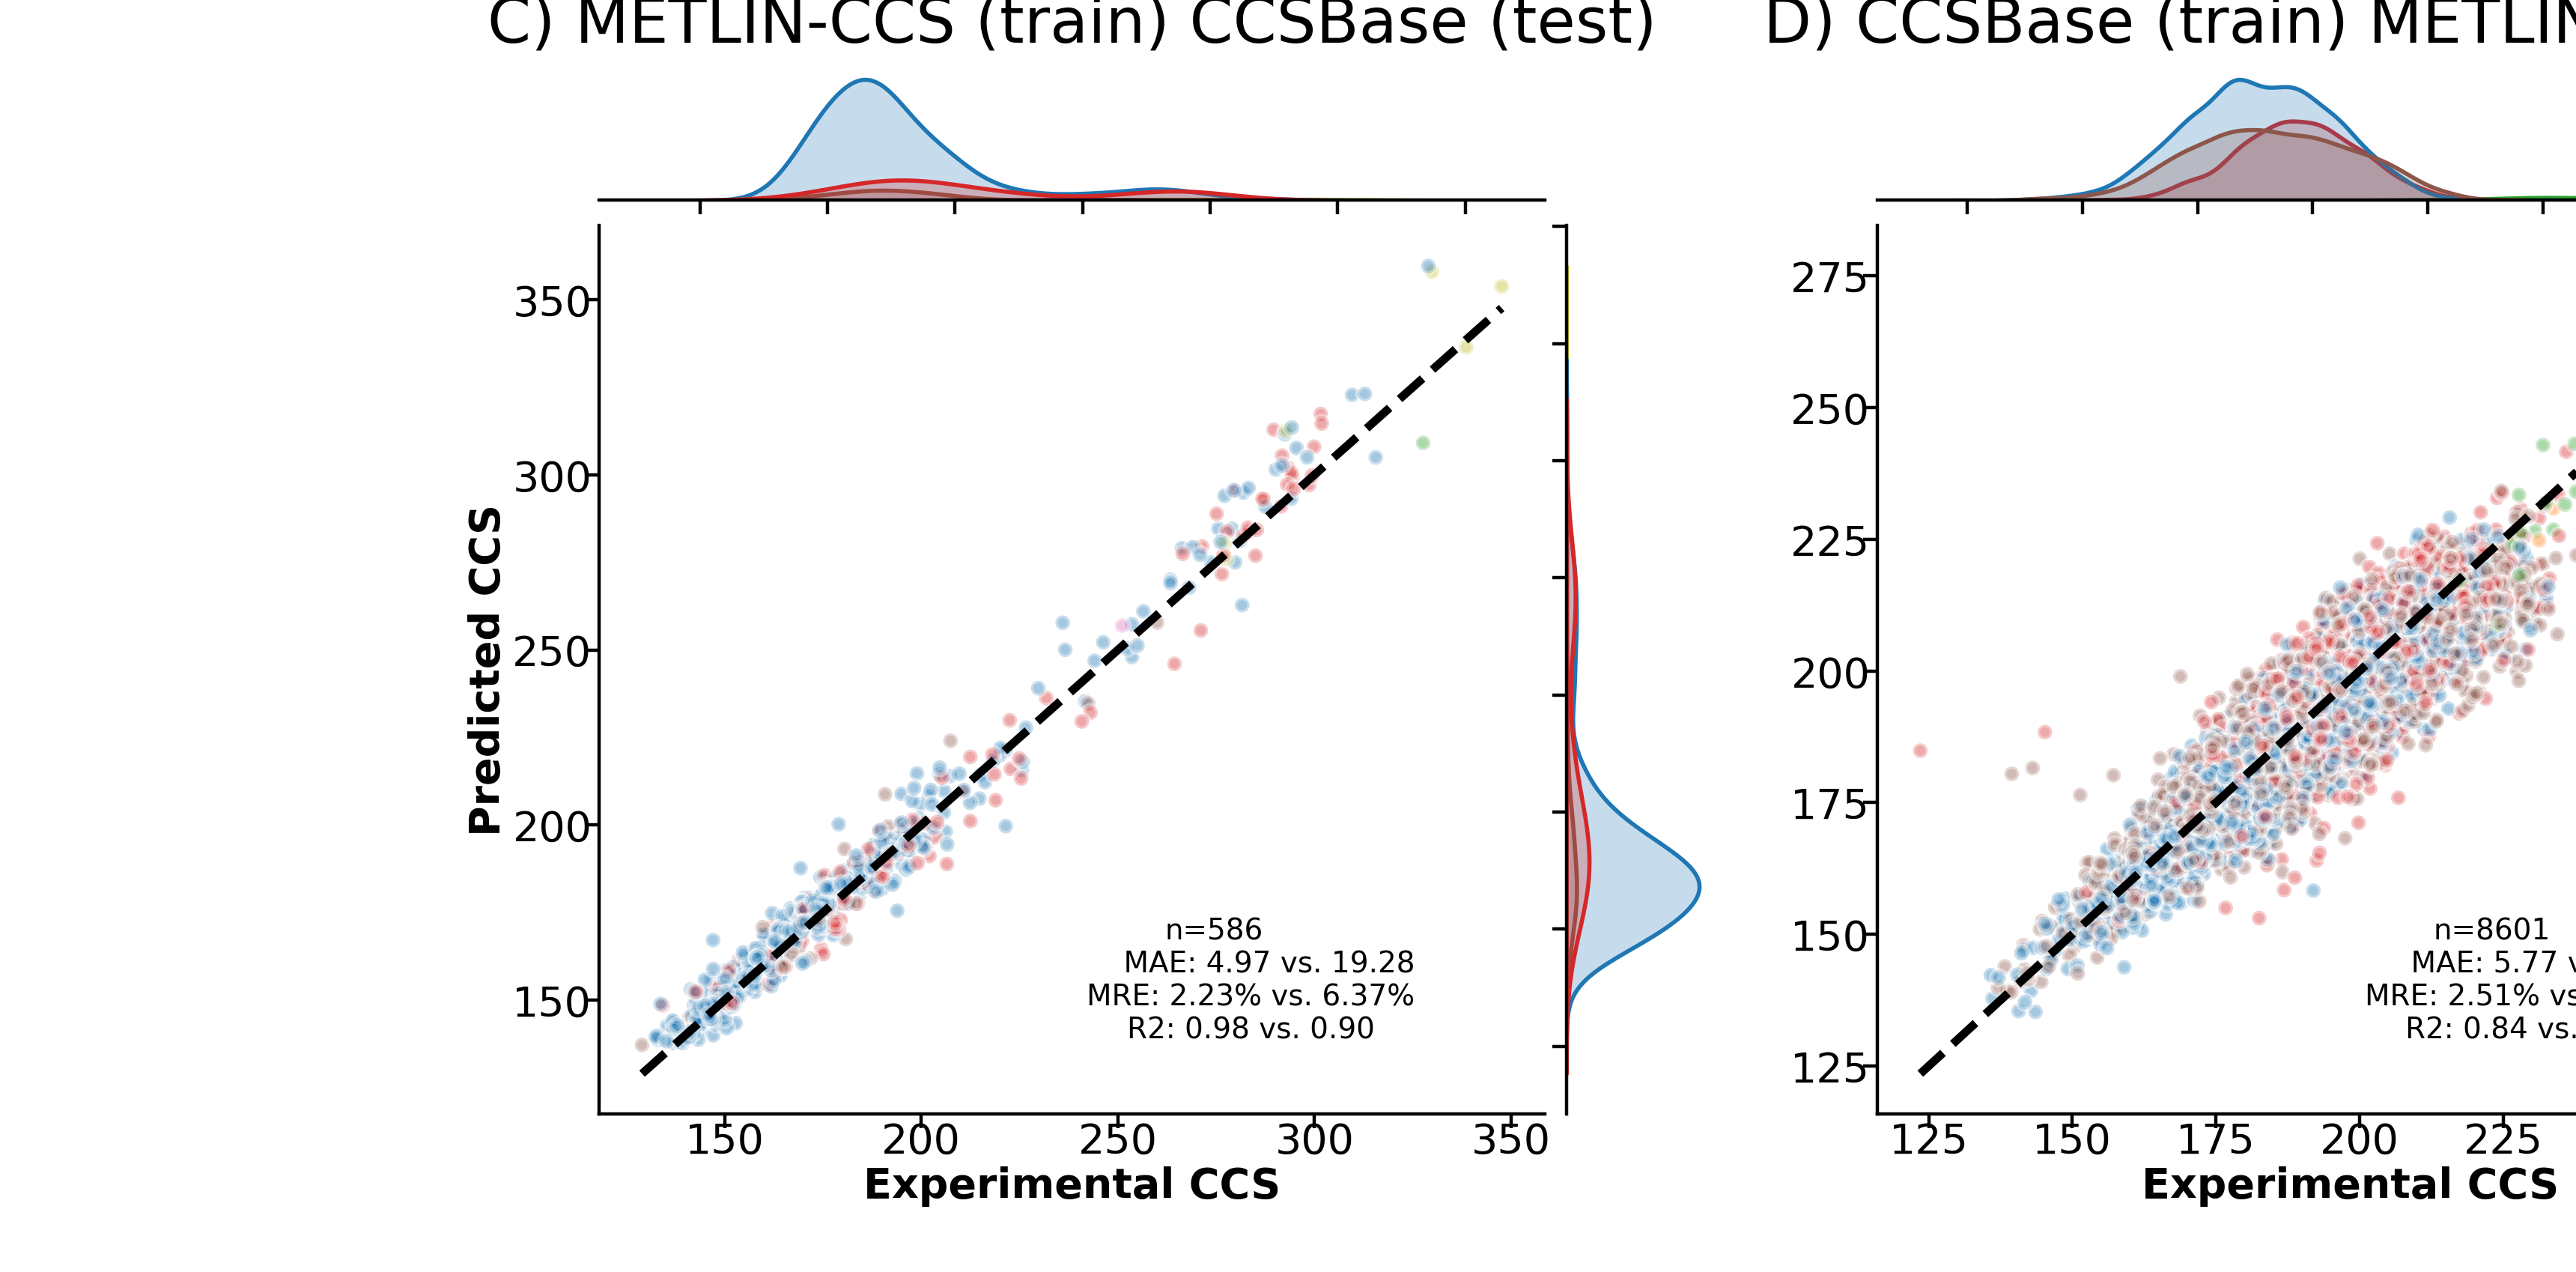

In [21]:
# Plot the distribution of the errors for the high confidence predictions using sns.joinplot

fig = plt.figure(figsize=(40, 20), dpi=400)
gs = gridspec.GridSpec(1, 2)

palette = {
    "[M+H]+": "#1f77b4",
    "[2M+H]+": "#ff7f0e",
    "[M+Na]+": "#d62728",
    "[2M+Na]+": "#2ca02c",
    "[M-H]-": "#8c564b",
    "[2M-H]-": "#9467bd",
    "[M+K]+": "#e377c2",
    "[M+H-H2O]+": "#7f7f7f",
    "[M+NH4]+": "#bcbd22",
}


for i, prediction_file in enumerate(high_confidence_preds):

    pred_df = high_confidence_preds[prediction_file]

    if i == 0:
        title = f"C) {name_style[prediction_file]}"
    else:
        title = f"D) {name_style[prediction_file]}"

    SeabornFig2Grid(
        plot_scatter(
            pred_df,
            palette,
            legend=False,  # True if i == 0 else False,
            y_label=True if i == 0 else False,
            title=title,
            original_metrics=original_metrics[prediction_file],
            high_confidence_metrics=high_confidence_metrics[prediction_file],
        ),
        fig,
        gs[i],
    )

plt.tight_layout()

# with legend
# # gs.update(top=0.99, bottom=0.22)

gs.update(top=0.80, left=0.2)
# save the figure
plt.savefig("figure_5.png", dpi=400)

plt.show()